### Code

#### Sentiment Anlysis:
1. TextBlob
2. VADER
3. BERT
4. OpenAI

- Overall Analysis over the 10 years
- Individual Tycoon Analysis over 10 years

In [ ]:
import requests  ## for getting data from a server GET
import re   ## for regular expressions
import pandas as pd    ## for dataframes and related
from pandas import DataFrame

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


from sklearn.model_selection import train_test_split
import random as rd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
#from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
## conda install python-graphviz
## restart kernel (click the little red x next to the Console)
#import graphviz  ##Couldn't load the library

from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn
from sklearn.cluster import KMeans

from sklearn import preprocessing

import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import ward, dendrogram

In [63]:
import requests
import pandas as pd
import time

def fetch_guardian_data(keyword, api_key, start_date, end_date):
    base_url = 'https://content.guardianapis.com/search'
    data = []
    page = 1
    max_retries = 5  # Number of retry attempts before giving up

    while True:
        params = {
            'q': keyword,
            'api-key': api_key,
            'page-size': 50,
            'show-fields': 'headline',
            'lang': 'en',
            'order-by': 'relevance',
            'from-date': start_date,
            'to-date': end_date,
            'page': page
        }

        retries = 0
        while retries < max_retries:
            try:
                response = requests.get(base_url, params=params)
                response.raise_for_status()  # Raises an HTTPError if the response code is 4xx/5xx

                # If we get a valid response, break the retry loop
                break

            except requests.exceptions.RequestException as e:
                if response.status_code == 429:  # Rate limiting error
                    retries += 1
                    sleep_time = 2 ** retries  # Exponential backoff (2^retries seconds)
                    print(f"Rate limit hit for keyword '{keyword}' on page {page}, retrying in {sleep_time} seconds...")
                    time.sleep(sleep_time)  # Wait before retrying
                else:
                    print(f"Request failed for keyword '{keyword}' on page {page}: {e}")
                    return pd.DataFrame()  # If any other error, break and return empty DataFrame
            else:
                break  # If request is successful, exit the retry loop

        # Check if the response contains results
        json_data = response.json()

        if 'response' not in json_data or 'results' not in json_data['response'] or not json_data['response']['results']:
            print(f"No more results for keyword '{keyword}' at page {page}.")
            break

        for article in json_data['response']['results']:
            data.append([keyword, article['webTitle'], article['webUrl'], article['webPublicationDate']])

        # Check if we've reached the last page
        total_pages = json_data['response']['pages']
        if page >= total_pages:
            print(f"Reached last page ({page}) for keyword '{keyword}'.")
            break

        page += 1

    data_df = pd.DataFrame(data, columns=['keyword', 'headline', 'url', 'publication_date'])
    return data_df

# Replace with your correct API key
api_key = '73b40d37-2c84-46d9-9c79-52e4cdac0f82'  # Use the new API key
start_date = '2014-01-01'
end_date = '2024-11-31'
keywords = ['Elon Musk', 'Jeff Bezos', 'Warren Buffet', 'Bill Gates', 'Larry Ellison']
all_data = pd.DataFrame()

for keyword in keywords:
    keyword_df = fetch_guardian_data(keyword, api_key, start_date, end_date)
    all_data = pd.concat([all_data, keyword_df], ignore_index=True)

# Save the data to CSV (Optional)
all_data.to_csv('guardian_articles.csv', index=False)

print(all_data.head())  # Print first few rows of the DataFrame to check


Rate limit hit for keyword 'Elon Musk' on page 1, retrying in 2 seconds...
Request failed for keyword 'Elon Musk' on page 1: 400 Client Error: Bad Request for url: https://content.guardianapis.com/search?q=Elon+Musk&api-key=73b40d37-2c84-46d9-9c79-52e4cdac0f82&page-size=50&show-fields=headline&lang=en&order-by=relevance&from-date=2014-01-01&to-date=2024-11-31&page=1
Request failed for keyword 'Jeff Bezos' on page 1: 400 Client Error: Bad Request for url: https://content.guardianapis.com/search?q=Jeff+Bezos&api-key=73b40d37-2c84-46d9-9c79-52e4cdac0f82&page-size=50&show-fields=headline&lang=en&order-by=relevance&from-date=2014-01-01&to-date=2024-11-31&page=1
Rate limit hit for keyword 'Warren Buffet' on page 1, retrying in 2 seconds...
Rate limit hit for keyword 'Warren Buffet' on page 1, retrying in 4 seconds...
Rate limit hit for keyword 'Warren Buffet' on page 1, retrying in 8 seconds...
Rate limit hit for keyword 'Warren Buffet' on page 1, retrying in 16 seconds...
Rate limit hit for

In [51]:
all_data = pd.read_csv("/content/guardian_articles.csv")

In [52]:
all_data

,keyword,headline,url,publication_date
0,Elon Musk,Why would Elon Musk want to deliberately destr...,https://www.theguardian.com/commentisfree/2023...,2023-12-02T14:00:46Z
1,Elon Musk,Neil Young boycotts X over antisemitic Elon Mu...,https://www.theguardian.com/music/2023/nov/21/...,2023-11-21T09:49:16Z
2,Elon Musk,Elon Musk spends $100m to open new university ...,https://www.theguardian.com/technology/2023/de...,2023-12-14T17:49:39Z
3,Elon Musk,Elon Musk visits scene of kibbutz massacre wit...,https://www.theguardian.com/world/2023/nov/27/...,2023-11-27T18:47:42Z
4,Elon Musk,"Elon Musk hurls defiant, profanity-laced retor...",https://www.theguardian.com/technology/2023/no...,2023-11-30T01:13:11Z
...,...,...,...,...
2895,Larry Ellison,CSIRO chief’s exit offers Labor rare opportuni...,https://www.theguardian.com/australia-news/202...,2022-11-19T19:00:05Z
2896,Larry Ellison,Pandora’s Box by Peter Biskind review – essent...,https://www.theguardian.com/books/2023/nov/24/...,2023-11-24T07:30:14Z
2897,Larry Ellison,Over the top: how to liven up soup | Kitchen aide,https://www.theguardian.com/food/2022/nov/08/o...,2022-11-08T14:00:03Z
2898,Larry Ellison,Global giants gear up to build streaming model...,https://www.theguardian.com/tv-and-radio/2023/...,2023-12-30T10:00:29Z


## Exploratory Data Analysis


Now generating sentiment labels using TextBlob.

In [55]:
pip install textblob

In [56]:
from textblob import TextBlob

# Function to get sentiment
def get_sentiment(text):
    # Create a TextBlob object
    analysis = TextBlob(text)
    # Polarity is within the range [-1, 1]
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to the headline column
all_data['Sentiment'] = all_data['headline'].apply(get_sentiment)

print(all_data[['headline', 'Sentiment']])

                                               headline Sentiment
0     Why would Elon Musk want to deliberately destr...  Negative
1     Neil Young boycotts X over antisemitic Elon Mu...  Positive
2     Elon Musk spends $100m to open new university ...  Positive
3     Elon Musk visits scene of kibbutz massacre wit...   Neutral
4     Elon Musk hurls defiant, profanity-laced retor...   Neutral
...                                                 ...       ...
2895  CSIRO chief’s exit offers Labor rare opportuni...  Positive
2896  Pandora’s Box by Peter Biskind review – essent...   Neutral
2897  Over the top: how to liven up soup | Kitchen aide  Positive
2898  Global giants gear up to build streaming model...   Neutral
2899  FTX assets worth $3.5bn held by Bahamas securi...  Positive

[2900 rows x 2 columns]


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
all_data["Sentiment"].value_counts()

,count
Sentiment,
Neutral,1483
Positive,868
Negative,549


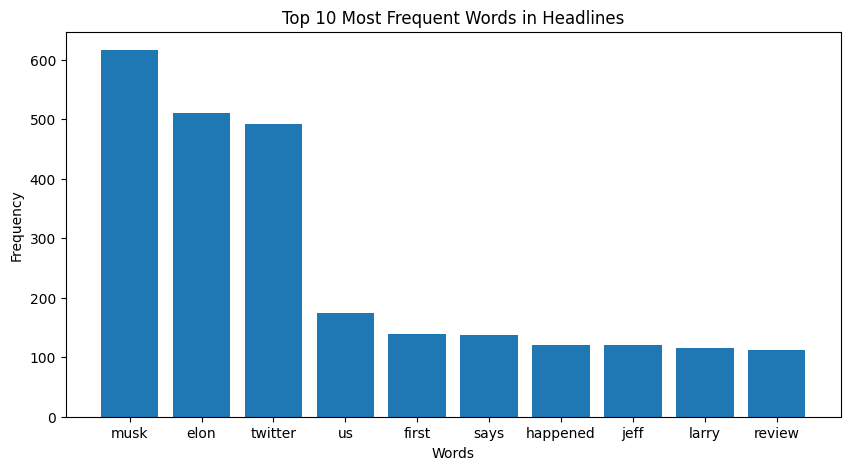

In [ ]:
import re
from collections import Counter
from nltk.corpus import stopwords
from string import punctuation
import matplotlib.pyplot as plt

stop_words = set(stopwords.words('english'))

def tokenize(text):
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)  # use regex to extract words
    words = [w for w in words if w not in stop_words]
    return words

all_words = []
for headline in all_data['headline']:
    all_words.extend(tokenize(headline))

word_counts = Counter(all_words)
top_words = word_counts.most_common(10)

plt.figure(figsize=(10, 5))
plt.bar([w[0] for w in top_words], [w[1] for w in top_words])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Words in Headlines')
plt.show()


In [57]:
import pandas as pd
from textblob import TextBlob

# Loading the data from the existing file (assuming 'all_data.csv' is the file containing all headlines)
#all_data = pd.read_csv('all_data.csv')

# Filtering headlines about Elon Musk
elon_data = all_data[all_data['keyword'].str.contains('Elon Musk')]

elon_data['Sentiment'] = elon_data['headline'].apply(get_sentiment)

elon_data[['headline', 'Sentiment']].to_csv('elon_musk_headlines_sentiments.csv', index=False)
elon_data

<ipython-input-57-b8cf077bcd44>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elon_data['Sentiment'] = elon_data['headline'].apply(get_sentiment)


,keyword,headline,url,publication_date,Sentiment
0,Elon Musk,Why would Elon Musk want to deliberately destr...,https://www.theguardian.com/commentisfree/2023...,2023-12-02T14:00:46Z,Negative
1,Elon Musk,Neil Young boycotts X over antisemitic Elon Mu...,https://www.theguardian.com/music/2023/nov/21/...,2023-11-21T09:49:16Z,Positive
2,Elon Musk,Elon Musk spends $100m to open new university ...,https://www.theguardian.com/technology/2023/de...,2023-12-14T17:49:39Z,Positive
3,Elon Musk,Elon Musk visits scene of kibbutz massacre wit...,https://www.theguardian.com/world/2023/nov/27/...,2023-11-27T18:47:42Z,Neutral
4,Elon Musk,"Elon Musk hurls defiant, profanity-laced retor...",https://www.theguardian.com/technology/2023/no...,2023-11-30T01:13:11Z,Neutral
...,...,...,...,...,...
2095,Elon Musk,"Elon Musk is already walking on air, never min...",https://www.theguardian.com/business/nils-prat...,2020-02-04T20:26:40Z,Neutral
2096,Elon Musk,Be wary of Elon Musk despoiling the ‘vault of ...,https://www.theguardian.com/commentisfree/2019...,2019-12-29T08:15:32Z,Negative
2097,Elon Musk,Hopes of ‘soft landing’ as US jobs growth slow...,https://www.theguardian.com/business/live/2023...,2023-08-04T15:36:39Z,Positive
2098,Elon Musk,Apple’s plan to scan images will allow governm...,https://www.theguardian.com/commentisfree/2021...,2021-10-16T15:00:02Z,Neutral


<ipython-input-58-a2a6f2f89de0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elon_data['Sentiment'] = elon_data['headline'].apply(get_sentiment)
<ipython-input-58-a2a6f2f89de0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elon_data['publication_date'] = pd.to_datetime(elon_data['publication_date'])
<ipython-input-58-a2a6f2f89de0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

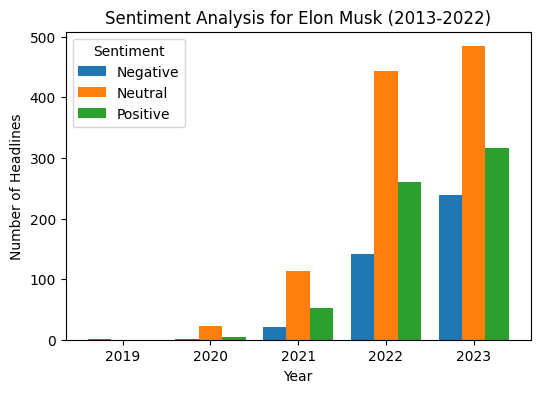

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

# Applying sentiment analysis on the headlines
elon_data['Sentiment'] = elon_data['headline'].apply(get_sentiment)

elon_data['publication_date'] = pd.to_datetime(elon_data['publication_date'])
elon_data['year'] = elon_data['publication_date'].dt.year

sentiment_by_year = elon_data.groupby(['year', 'Sentiment']).size().unstack(fill_value=0)

sentiment_by_year.plot(kind='bar', figsize=(6, 4), width=0.8)
plt.xlabel('Year')
plt.ylabel('Number of Headlines')
plt.title('Sentiment Analysis for Elon Musk (2013-2022)')
plt.legend(title='Sentiment', loc='upper left')
plt.xticks(rotation=0)
plt.show()


In [59]:
import pandas as pd
from textblob import TextBlob

# Filtering headlines about Elon Musk
jeff_data = all_data[all_data['keyword'].str.contains('Jeff Bezos')]

# Applying the function to the headline column
jeff_data['Sentiment'] = jeff_data['headline'].apply(get_sentiment)

jeff_data[['headline', 'Sentiment']].to_csv('jess_headlines_sentiments.csv', index=False)
jeff_data

<ipython-input-59-e00593cf86aa>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeff_data['Sentiment'] = jeff_data['headline'].apply(get_sentiment)


,keyword,headline,url,publication_date,Sentiment
2100,Jeff Bezos,Jeff Bezos wore a cowboy hat again. Real cowbo...,https://www.theguardian.com/fashion/2023/nov/1...,2023-11-19T13:00:04Z,Positive
2101,Jeff Bezos,Emmanuel Macron criticised for giving Légion d...,https://www.theguardian.com/world/2023/feb/23/...,2023-02-23T18:16:53Z,Neutral
2102,Jeff Bezos,Twelve billionaires’ climate emissions outpoll...,https://www.theguardian.com/environment/2023/n...,2023-11-20T00:01:04Z,Neutral
2103,Jeff Bezos,Who wants to live for ever? Only billionaires ...,https://www.theguardian.com/commentisfree/2023...,2023-01-08T14:00:50Z,Positive
2104,Jeff Bezos,Jeff Bezos sued by former housekeeper alleging...,https://www.theguardian.com/technology/2022/no...,2022-11-03T12:23:19Z,Neutral
...,...,...,...,...,...
2445,Jeff Bezos,Kevin Rudd accuses News Corp of ‘dog-whistling...,https://www.theguardian.com/australia-news/202...,2022-11-08T07:13:45Z,Neutral
2446,Jeff Bezos,Monday briefing: Who was really to blame for t...,https://www.theguardian.com/world/2023/nov/13/...,2023-11-13T06:49:14Z,Neutral
2447,Jeff Bezos,Theatregoers to be petitioned outside Australi...,https://www.theguardian.com/culture/2023/dec/0...,2023-12-05T14:00:44Z,Neutral
2448,Jeff Bezos,"Chris Kamara: ‘People say ‘Unbelievable, Jeff!...",https://www.theguardian.com/football/2022/may/...,2022-05-21T17:00:25Z,Negative


<ipython-input-60-3b9b6e1ffc10>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeff_data['Sentiment'] = jeff_data['headline'].apply(get_sentiment)
<ipython-input-60-3b9b6e1ffc10>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jeff_data['publication_date'] = pd.to_datetime(jeff_data['publication_date'])
<ipython-input-60-3b9b6e1ffc10>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

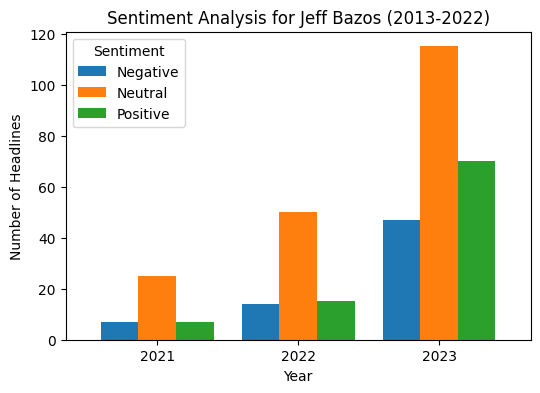

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

# Applying sentiment analysis on the headlines
jeff_data['Sentiment'] = jeff_data['headline'].apply(get_sentiment)

jeff_data['publication_date'] = pd.to_datetime(jeff_data['publication_date'])
jeff_data['year'] = jeff_data['publication_date'].dt.year

sentiment_by_year = jeff_data.groupby(['year', 'Sentiment']).size().unstack(fill_value=0)

sentiment_by_year.plot(kind='bar', figsize=(6, 4), width=0.8)
plt.xlabel('Year')
plt.ylabel('Number of Headlines')
plt.title('Sentiment Analysis for Jeff Bazos (2013-2022)')
plt.legend(title='Sentiment', loc='upper left')
plt.xticks(rotation=0)
plt.show()


<ipython-input-61-8d57066f282f>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  all_data['month_year'] = all_data['date'].dt.to_period('M')


<Figure size 1200x600 with 0 Axes>

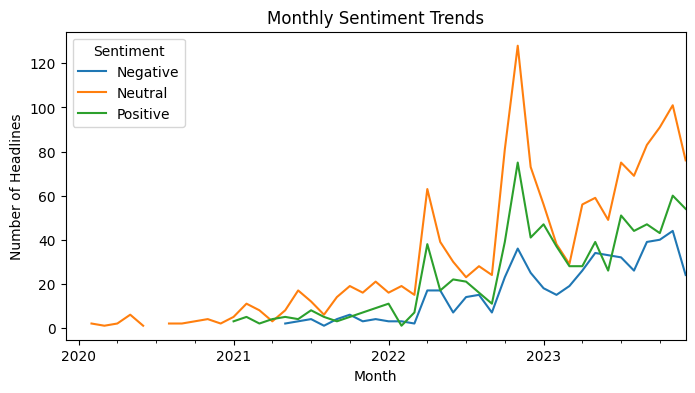

In [61]:
all_data['date'] = pd.to_datetime(all_data['publication_date'])
all_data['month_year'] = all_data['date'].dt.to_period('M')

monthly_senti = all_data.groupby(['month_year', 'Sentiment']).size().unstack()

plt.figure(figsize=(12, 6))
monthly_senti.plot(kind='line', figsize=(8, 4))
plt.title('Monthly Sentiment Trends')
plt.xlabel('Month')
plt.ylabel('Number of Headlines')
plt.show()

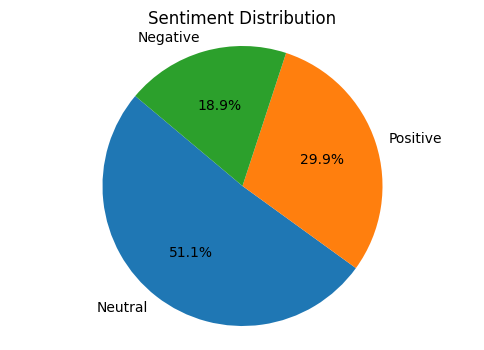

In [62]:
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment
sentiment_counts = all_data['Sentiment'].value_counts()

# Create the pie chart
plt.figure(figsize=(6, 4))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the plot
plt.show()
